# Min Cost Flow problem

In [44]:
#!conda config --add channels conda-forge
#!conda install shapely
#!pip install --user -I matplotlib
#!pip install --user -I geopandas
import gurobipy as grb
import pandas as pd
import numpy as np
import os
import scipy.sparse as sp

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from shapely.geometry import Point, LineString
import geopandas as gpd

AttributeError: type object 'fiona.ogrext.FeatureBuilder' has no attribute '__reduce_cython__'

## NYC Subway network

In [11]:
thepath = os.path.join(os.getcwd(),'..')
arcs = pd.read_csv(os.path.join(thepath,'data_mec_optim/networks_subway/NYC/arcs.csv'), sep=',')#.sort_values(by=['route_id'])
nodes = pd.read_csv(os.path.join(thepath, 'data_mec_optim/networks_subway/NYC/nodes.csv'), sep=',')

Stations' caracteristics are contained in nodes dataframe:

In [12]:
nodes.head()

,stop_name,flow,stop_lat,stop_lon,stop_id,stop_nb,route_id
0,Van Cortlandt Park - 242 St,1000,40.889248,-73.898583,101,1,(1)
1,238 St,1000,40.884667,-73.900870,103,2,(1)
2,231 St,1000,40.878856,-73.904834,104,3,(1)
3,Marble Hill - 225 St,1000,40.874561,-73.909831,106,4,(1)
4,215 St,1000,40.869444,-73.915279,107,5,(1)


Routes between stations are contained in arcs dataframe:

In [13]:
arcs.head()

,from_stop_nb,to_stop_nb,dis_line,min_time_elapsed,from_stop_id,to_stop_id,route_id
0,185,10,15000.0,0.18,A09,112,NaN
1,198,23,15000.0,0.18,A24,125,NaN
2,448,25,15000.0,0.18,R16,127,NaN
3,179,25,15000.0,0.18,902,127,NaN
4,200,25,25000.0,0.30,A27,127,NaN


In [14]:
print(len(nodes))
print(len(arcs))

501
1290


In [24]:
nb_nodes = len(nodes)
names_nodes = nodes['stop_name'] + ' ' + nodes['route_id']
arcs_list = [(i, j) for i, j in zip(arcs['from_stop_nb'], arcs['to_stop_nb'])]
Phi = -arcs['min_time_elapsed'].values
nb_arcs = len(Phi)

In [25]:
origin_node = 452# #Union Sq - we minus 1 because of python's 0 indexing
destination_node = 471 # 59 St

In [26]:
Nabla = sp.csr_matrix(([-1 for i in range(nb_arcs)], (list(range(nb_arcs)), [i - 1 for i,j in arcs_list])), shape = (nb_arcs,nb_nodes)) + \
sp.csr_matrix(([1 for i in range(nb_arcs)], (list(range(nb_arcs)), [j - 1 for i,j in arcs_list])), shape = (nb_arcs,nb_nodes)) 

In [41]:
m=grb.Model('NYC Subway')
x = m.addMVar(shape=nb_arcs, name="x")
m.setObjective(Phi @ x, grb.GRB.MAXIMIZE)
# we minus 1 for the nodes because of python's 0 indexing
rhs = np.asarray([-1 if x==(origin_node - 1) else 1 if  x==(destination_node - 1) else 0 for x in range(nb_nodes)])
m.addConstr(Nabla.T @ x == rhs, name="Constr")
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 501 rows, 1290 columns and 2580 nonzeros
Model fingerprint: 0x4770dff3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 499 rows and 493 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible or unbounded model


In [28]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [29]:
i = origin_node - 1
path_list = [i]
step = 1
if m.status == grb.GRB.Status.OPTIMAL:
    print('***Optimal solution***')
    print('Minimum distance from', names_nodes[origin_node - 1], 'to',
          names_nodes[destination_node - 1], '\n', m.objVal)
    print('0 :', names_nodes[origin_node - 1], '(#%d)' % origin_node)
    solution = x.X
    eqpath = np.argwhere(solution > 0)[:, 0]
    while i != destination_node - 1:
        leavingi = np.argwhere(Nabla[:,i] == -1)[:,0]
        a = intersection(list(leavingi), list(eqpath))[0]
        j = np.argwhere(Nabla[a,:] == 1)[0][1]
        print(step, ':', names_nodes[i], '(#%d)' % (i + 1),  'to', names_nodes[j], '(#%d)' % (j + 1))
        step += 1
        path_list.append(j)
        i = j

***Optimal solution***
Minimum distance from 14 St - Union Sq (N/R/Q) to 59 St (R/N) 
 -1350.3
0 : 14 St - Union Sq (N/R/Q) (#452)
1 : 14 St - Union Sq (N/R/Q) (#452) to Canal St (Q/N) (#433)
2 : Canal St (Q/N) (#433) to DeKalb Av (N/D/Q) (#462)
3 : DeKalb Av (N/D/Q) (#462) to Atlantic Av - Barclays Ctr (Q) (#269)
4 : Atlantic Av - Barclays Ctr (Q) (#269) to Atlantic Av - Barclays Ctr (D/N/R) (#463)
5 : Atlantic Av - Barclays Ctr (D/N/R) (#463) to 36 St (R/D/N) (#468)
6 : 36 St (R/D/N) (#468) to 59 St (R/N) (#471)


In [30]:
# For reasons I do not understand
path_list = [x + 1 for x in path_list]

In [31]:
geometry_nodes = [Point(xy) for xy in zip(nodes['stop_lon'], nodes['stop_lat'])]
gdf_nodes = gpd.GeoDataFrame(nodes,geometry=geometry_nodes)
gdf_nodes.head()

NameError: name 'gpd' is not defined

In [23]:
arcs_coord_int = pd.merge(arcs[['from_stop_id', 'to_stop_id']].rename(index=str, columns={'from_stop_id': 'stop_id'}), 
         gdf_nodes[['stop_id', 'geometry']].rename(index=str, columns={'geometry': 'from_geometry'}), 
         on = 'stop_id').rename(index=str, columns={'stop_id': 'from_stop_id'})

arcs_coord = pd.merge(arcs_coord_int.rename(index=str, columns={'to_stop_id': 'stop_id'}),
                     gdf_nodes[['stop_id', 'geometry']].rename(index=str, columns={'geometry': 'to_geometry'}),
                     on = 'stop_id').rename(index=str, columns={'stop_id': 'to_stop_id'})
del arcs_coord_int
arcs_coord.head()

NameError: name 'gdf_nodes' is not defined

In [309]:
geometry_arcs = [LineString(xy) for xy in zip(arcs_coord['from_geometry'],arcs_coord['to_geometry'])]
gdf_arcs = gpd.GeoDataFrame(arcs,geometry=geometry_arcs)
gdf_arcs.head()

,from_stop_nb,to_stop_nb,dis_line,min_time_elapsed,from_stop_id,to_stop_id,route_id,geometry
0,185,10,15000.0,0.18,A09,112,NaN,"LINESTRING (-73.93956 40.84072, -73.94013 40.8..."
1,198,23,15000.0,0.18,A24,125,NaN,"LINESTRING (-73.93360 40.84951, -73.94013 40.8..."
2,448,25,15000.0,0.18,R16,127,NaN,"LINESTRING (-73.94489 40.83404, -73.94013 40.8..."
3,179,25,15000.0,0.18,902,127,NaN,"LINESTRING (-73.93956 40.84072, -73.93970 40.8..."
4,200,25,25000.0,0.30,A27,127,NaN,"LINESTRING (-73.93797 40.85169, -73.93970 40.8..."


In [310]:
def animate(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    stop_id = gdf_arcs[gdf_arcs["to_stop_nb"]==path_list[i]]['to_stop_id'].values[0]
    stop_to_plot = gdf_nodes[gdf_nodes["stop_id"]==stop_id]

    ax.text(stop_to_plot['stop_lon'], stop_to_plot['stop_lat'],stop_to_plot['stop_name'].values[0], 
            size = 'medium', fontweight='bold')
    stop_to_plot.plot(marker = 'o', color = 'green', markersize=50, ax=ax)

    ax.set_xlabel(label)
    return ax

<IPython.core.display.Javascript object>


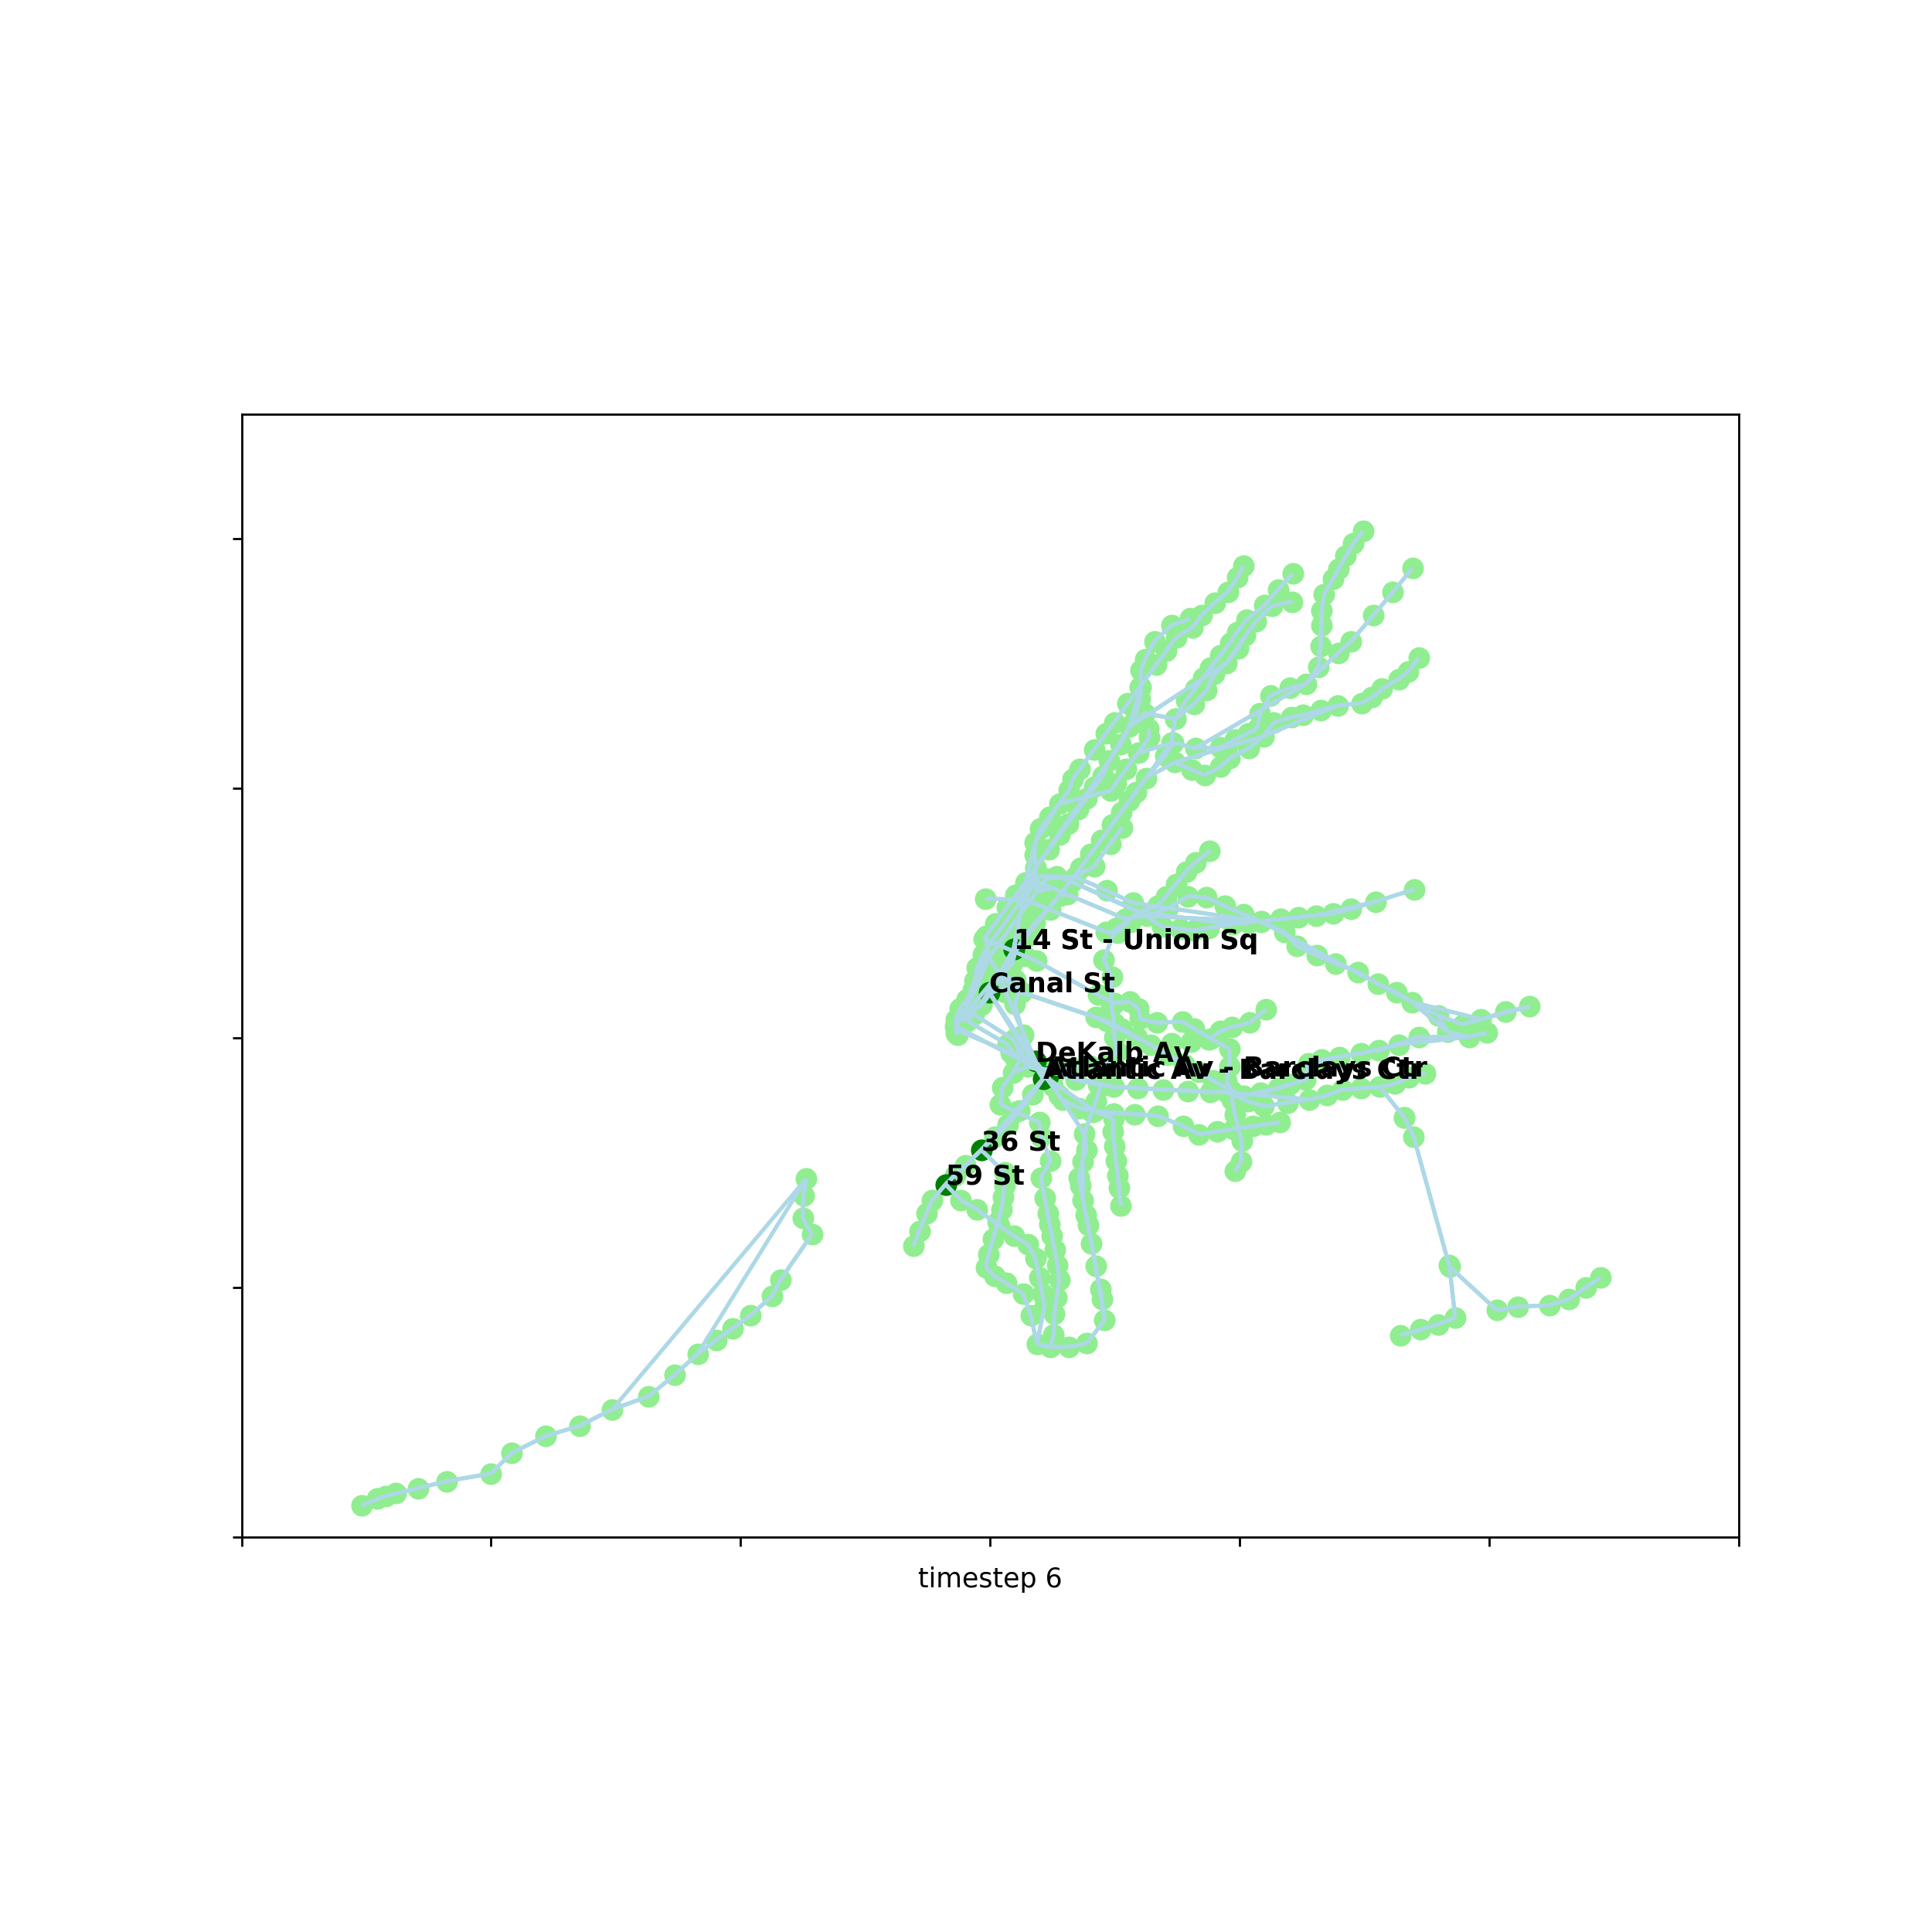

In [311]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-74.3, -73.7])
ax.set_ylim([40.5, 40.95])
ax.set_yticklabels([])
ax.set_xticklabels([])

gdf_arcs.plot(color = 'lightblue',ax=ax)
gdf_nodes.plot(marker = 'o', color = 'lightgreen', markersize=50, ax=ax)

In [312]:
anim = FuncAnimation(fig, animate, frames = np.arange(0, len(path_list)), interval = 2000, repeat = False)
plt.show()